# __Demo: Implementing a Variational Autoencoder (VAE) with TensorFlow for Image Generation Using the MNIST Dataset__

# __Steps to Perform__

Step 1: Import the Necessary Libraries

Step 2: Load the MNIST Dataset

Step 3: Set Hyperparameters

Step 4: Define Model Architecture

Step 5: Define the Sampling Function

Step 6: Connect the Encoder and Decoder

Step 7: Define the Loss Function and Compile the Model

Step 8: Train the Model

Step 9: Generate a Manifold of Digits

# __Step 1: Import the Necessary Libraries__
- Import numpy, matplotlib.pyplot, and tensorflow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # pip install tensorflow

In [2]:
tf.__version__

'2.15.0'

# __Step 2: Load the MNIST Dataset__

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data() # not interested in the labels
x_train, x_test = x_train / 255.0, x_test / 255.0 # scale between 0 and 1

# __Step 3: Set Hyperparameters__
-  Define the `learning_rate`, `num_steps`, and `batch_size`.
- `learning_rate` is the step size at each iteration while moving toward a minimum of a loss function.
- `num_steps` is the number of steps you want to train the model.
- `batch_size` is the number of samples that will be propagated through the network.

In [4]:
learning_rate = 0.001
num_steps = 100
batch_size = 64 # default 32

- In the next steps, you will define the architecture of the VAE, including the encoder and decoder networks and the loss function.

# __Step 4: Define Model Architecture__
- Construct the VAE using `tf.keras` that defines the encoder and decoder using keras layers.

In [5]:
latent_dim = 2 # Example latent space dimension. can be anything lower than original image dim
# try with a higher value for latent_dim = for eg 256

# Define the encoder part
encoder_inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Flatten()(encoder_inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x) # also try adding a few more leyers with progressively smaller dimension eg 784-512-384-256
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Define the decoder part
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(512, activation='relu')(latent_inputs) # 256-384-512-784 - reshape to 28x28
x = tf.keras.layers.Dense(784, activation='sigmoid')(x)
decoder_outputs = tf.keras.layers.Reshape((28, 28))(x)

2025-02-23 13:08:13.295523: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-23 13:08:13.295914: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-23 13:08:13.296519: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-23 13:08:13.297155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-23 13:08:13.297618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# __Step 5: Define the Sampling Function__

-  Create a custom Keras layer for the sampling function used in the VAE.

In [6]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer that implements the reparameterization trick for Variational Autoencoders (VAE).
    This layer samples points from the latent space distribution defined by z_mean and z_log_var,
    using the reparameterization trick to allow backpropagation through the sampling process.
    The trick works by separating the random sampling into a deterministic function of random input,
    enabling gradient flow while maintaining stochastic behavior.
    
    Inputs:
        - z_mean: Mean vector of the latent distribution
        - z_log_var: Log variance vector of the latent distribution
    
    Returns:
        - A sampled point from the latent distribution that can be backpropagated through
    """
    def call(self, inputs):
        # inputs is a tuple of (z_mean, z_log_var) representing the parameters of the latent space distribution
        z_mean, z_log_var = inputs
        
        # Get the batch size and latent dimension from z_mean tensor shape
        batch = tf.shape(z_mean)[0]  # Number of samples in the batch
        dim = tf.shape(z_mean)[1]    # Dimension of the latent space
        
        # Generate random samples from a standard normal distribution (mean=0, std=1)
        # These act as our source of randomness for the sampling process
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        # Implement the reparameterization trick: z = μ + σ * ε
        # where: 
        # - z_mean (μ) is the mean of the latent distribution
        # - exp(0.5 * z_log_var) is the standard deviation σ (we use exp because z_log_var = log(σ²))
        # - epsilon (ε) is the random noise from standard normal distribution
        # This trick allows backpropagation through the random sampling process
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
    def call(self, inputs):
        # inputs is a tuple of (z_mean, z_log_var) representing the parameters of the latent space distribution
        z_mean, z_log_var = inputs
        
        # Get the batch size and latent dimension from z_mean tensor shape
        batch = tf.shape(z_mean)[0]  # Number of samples in the batch
        dim = tf.shape(z_mean)[1]    # Dimension of the latent space
        
        # Generate random samples from a standard normal distribution (mean=0, std=1)
        # These act as our source of randomness for the sampling process
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        # Implement the reparameterization trick: z = μ + σ * ε
        # where: 
        # - z_mean (μ) is the mean of the latent distribution
        # - exp(0.5 * z_log_var) is the standard deviation σ (we use exp because z_log_var = log(σ²))
        # - epsilon (ε) is the random noise from standard normal distribution
        # This trick allows backpropagation through the random sampling process
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# __Step 6: Connect the Encoder and the Decoder__

- Use keras functional API to connect the encoder and decoder parts of the VAE.

In [7]:
# Sample points from the latent space using the Sampling layer
# Takes z_mean and z_log_var as inputs and returns sampled points using the reparameterization trick
encoder_outputs = Sampling()([z_mean, z_log_var])

# Create the encoder model with:
# - Input: Original images (encoder_inputs)
# - Outputs: [z_mean, z_log_var, sampled_points]
# This gives us access to both the distribution parameters and the sampled points
encoder = tf.keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, encoder_outputs])

# Create the decoder model with:
# - Input: Points from latent space (latent_inputs)
# - Output: Reconstructed images (decoder_outputs)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=decoder_outputs)

# Connect encoder and decoder to create the full VAE:
# 1. encoder(encoder_inputs) returns [z_mean, z_log_var, sampled_points]
# 2. [2] selects the sampled_points (third output)
# 3. decoder takes these sampled points and reconstructs the image
vae_outputs = decoder(encoder(encoder_inputs)[2])

# Create the complete VAE model:
# - Input: Original images (encoder_inputs)
# - Output: Reconstructed images (vae_outputs)
# This is the full autoencoder that will be trained end-to-end
vae = tf.keras.Model(inputs=encoder_inputs, outputs=vae_outputs)

- In the next steps, you will define the loss function and train the model. After training, you can use the model to generate new images.

# __Step 7: Define the Loss Function and Compile the Model__
- The loss function in VAE typically includes a reconstruction loss and a KL divergence loss.

In [8]:
# Define the VAE loss within the VAE model class
class VAE(tf.keras.Model):
    """
    Variational Autoencoder (VAE) implementation that combines encoder and decoder networks.
    
    The VAE learns to encode data into a probability distribution (rather than a fixed vector)
    and decode samples from this distribution back to the original data space.
    
    The model is trained by minimizing two losses:
    1. Reconstruction loss: How well the decoded samples match the original input
    2. KL divergence loss: How close the learned distribution is to a standard normal distribution
    
    Args:
        encoder: The encoder model that converts input to latent space parameters
        decoder: The decoder model that reconstructs input from latent space samples
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder  # Store encoder model
        self.decoder = decoder  # Store decoder model

    def compute_loss(self, x):
        """
        Compute the VAE loss function which consists of reconstruction loss and KL divergence.
        
        Args:
            x: Input data to be reconstructed
            
        Returns:
            Total loss (reconstruction_loss + kl_loss)
        """
        # Get the latent space parameters and sampled point
        z_mean, z_log_var, z = self.encoder(x)
        
        # Reconstruct the input using the sampled point
        reconstructed = self.decoder(z)
        
        # Calculate reconstruction loss (binary cross-entropy)
        # This measures how well the decoder reconstructs the input
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x, reconstructed)
        )
        
        # Scale the loss by image dimensions (28x28) to maintain similar magnitude as KL loss
        # Without scaling: The reconstruction loss (eg.≈0.01) would be too small compared to KL loss (≈0.5)
        # with scaling: both reconstruction loss and KL loss are comparable. This ensures that 
        # both objectives (good reconstruction AND proper latent space distribution) are balanced

        reconstruction_loss *= 28 * 28
        
        # Calculate KL divergence loss
        # This measures how much the learned distribution differs from the prior (standard normal)
        # Formula: KL(N(μ, σ) || N(0, 1)) = -0.5 * sum(1 + log(σ²) - μ² - σ²)
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)  # Average over all dimensions
        kl_loss *= -0.5  # Scale factor from the KL divergence formula
        
        # Return total loss (sum of reconstruction and KL divergence losses)
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        """
        Perform one training step on a batch of data.
        
        Args:
            data: A batch of training data, possibly wrapped in a tuple
            
        Returns:
            Dictionary containing the training loss
        """
        # Handle the case where data comes as a tuple (e.g., with labels we don't need)
        if isinstance(data, tuple):
            data = data[0]
        
        # Use gradient tape to track operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Compute the loss for this batch
            loss = self.compute_loss(data)
        
        # Compute gradients of the loss with respect to trainable variables
        grads = tape.gradient(loss, self.trainable_variables)
        
        # Apply the gradients to update model weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        # Return loss metric for logging
        return {'loss': loss}

# Create VAE instance by combining the pre-defined encoder and decoder
vae = VAE(encoder, decoder)

# Compile the model with Adam optimizer
# No need to specify loss function as it's custom-defined in the model
vae.compile(optimizer='adam')

# __Step 8: Train the Model__

In [10]:
vae.fit(x_train, x_train, epochs=num_steps, batch_size=batch_size)

Epoch 1/100


2025-02-23 13:21:49.822981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 15s 12ms/step - loss: 5186.8795
Epoch 2/100
938/938 [==============================] - 10s 11ms/step - loss: 1173.6249
Epoch 3/100
938/938 [==============================] - 10s 11ms/step - loss: 6617.2742
Epoch 4/100
938/938 [==============================] - 10s 11ms/step - loss: 7154.6378
Epoch 5/100
938/938 [==============================] - 10s 11ms/step - loss: 2490.8626
Epoch 6/100
938/938 [==============================] - 11s 11ms/step - loss: 7070.5504
Epoch 7/100
938/938 [==============================] - 10s 10ms/step - loss: 4868.0782
Epoch 8/100
938/938 [==============================] - 10s 10ms/step - loss: 2764.3214
Epoch 9/100
938/938 [==============================] - 10s 10ms/step - loss: 5861.1434
Epoch 10/100
938/938 [==============================] - 10s 11ms/step - loss: 2897.2745
Epoch 11/100
938/938 [==============================] - 10s 11ms/step - loss: 2486.6347
Epoch 12/100
938/938 [==============================]

In [9]:
60000/64 # number of batches in one epoch

937.5

# __Step 9: Generate a Manifold of Digits__
- Generate a manifold of digits by creating a latent space grid.
- Feed these grid values into the decoder to produce images.

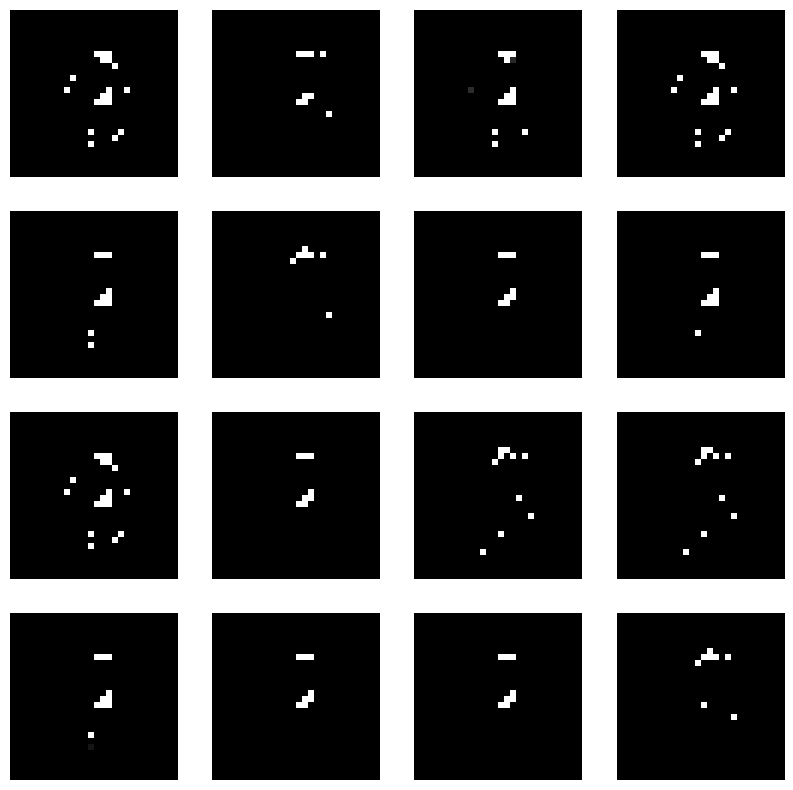

In [11]:
def generate_images(model, n_images):
    """
    Generate and display new images using a trained VAE model.
    
    This function performs three main steps:
    1. Creates random points in the latent space
    2. Uses the decoder to convert these points into images
    3. Displays the generated images in a grid layout
    
    Args:
        model: The trained VAE model containing the decoder
        n_images: Number of images to generate and display
        
    Note:
        - Generated images will be displayed in a 4-column grid
        - Each image is 28x28 pixels (MNIST size) in grayscale
    """
    # Step 1: Create random points in the latent space
    # - shape=(n_images, latent_dim) means we want n_images samples, each with latent_dim features
    # - tf.random.normal generates points from a standard normal distribution (mean=0, std=1)
    # - This mimics the distribution we trained our VAE to create
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    
    # Step 2: Use the decoder to convert these random points into images
    # - model.decoder converts points from latent space back to image space
    # - The output will be n_images of 28x28 pixels each
    generated_images = model.decoder(random_latent_vectors)
    
    # Convert TensorFlow tensor to NumPy array for plotting
    # - .numpy() converts TensorFlow tensor to a format matplotlib can use
    generated_images = generated_images.numpy()

    # Calculate how many rows we need in our grid
    # - We want 4 images per row (hence dividing by 4)
    # - np.ceil rounds up to ensure we have enough rows
    # - int converts the float to integer for subplot
    n_rows = int(np.ceil(n_images / 4))

    # Create a new figure for plotting with size 10x10 inches
    plt.figure(figsize=(10, 10))
    
    # Loop through each image and plot it
    for i in range(n_images):
        # Create a subplot in our grid
        # - n_rows: number of rows in grid
        # - 4: number of columns (we fixed this to 4)
        # - i + 1: current position (adding 1 because subplot counts from 1, not 0)
        plt.subplot(n_rows, 4, i + 1)
        
        # Display the image
        # - reshape(28, 28): convert flat array to 28x28 pixel image
        # - cmap='gray': use grayscale colormap (MNIST images are black and white)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        
        # Remove axes for cleaner display
        plt.axis('off')
    
    # Show the entire grid of images
    plt.show()

# Generate and display images
generate_images(vae, 16)

# __Conclusion__

In this demonstration, we have successfully implemented and trained a Variational Autoencoder (VAE) using TensorFlow to generate images based on the MNIST dataset. The process encompassed several critical steps, from importing necessary libraries to training the model, and finally, generating a manifold of digits.